In [170]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Model </h1>

I consider the scattering of only one photon towards a 2-level atom. Also, I assume that several atoms might be in the waveguide (to play the role of a mirror for instance). I work in the subspace :

$$ \ket{1,0}, \ket{0,1} $$

And the Hamiltonian is given by: 

$$ H = \sum_k \omega_k a_k^{\dagger} a_k + \frac{1}{2} \sum_j \Omega_j (1 + \sigma_j^z) + \sum_{k,j}\left\{g(k,j) \sigma^+ a_k + \text{h.c} \right\} $$

with $g(k,j) = i g_0 \sqrt{\omega_k} e^{ikx_j}$

<h1> Conduct time evolution </h1>

In [171]:
def get_data_mirror(L, N, T, dt, n_modes_init, omega_0, omega_A, n_A, g_0, x_A, sigma, x_0, use_WW_approx):
    #space discretization
    position_lattice_list = np.linspace(-L/2, L/2, N)
    #quantization of the modes
    k_tab = np.array([2*pi*n/L for n in range(-(n_modes_init//2),n_modes_init//2+1)])
    omega_tab = np.abs(k_tab) #tab of frequencies (with engough points to get omega_0)
    n_modes = len(k_tab) #adjust if necessary

    #tab of couplings
    g_tab = np.zeros((n_modes, n_A), dtype=complex)
    for i in range(n_modes):
        for j in range(n_A):
            if use_WW_approx:
                g_tab[i, j] = g_0*np.sqrt(omega_A)*np.exp(-1j*x_A*k_tab[i])*1j
            else:
                g_tab[i, j] = g_0*np.sqrt(omega_tab[i])*np.exp(-1j*x_A*k_tab[i])*1j #in my case, g is independant of the atom index

    #Creation of the Hamiltonian
    dim_subspace = n_modes + n_A
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    for i in range(n_A):
        H_matrix[n_modes+i, n_modes+i] = omega_A

    ##of diagonal elements
    for i in range(n_modes):
        for j in range(n_A):
            H_matrix[n_modes+j, i] = g_tab[i, j]
            H_matrix[i,n_modes+j] = np.conjugate(H_matrix[n_modes+j,i])

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None

    ##Operators of interest
    occupation_nb_photon_momentum_list = []
    occupation_nb_photon_position_list = []
    occupation_nb_total_atom = 0

    #occupation number operators in momentum space
    for i in range(n_modes):
        occupation_nb_photon_momentum_list.append(qt.basis(dim_subspace, i) * qt.basis(dim_subspace, i).dag())

    #Fourier transform to get the occupation number operators in position space
    for x in range(N):
        position = position_lattice_list[x]
        position_state = 0
        for i in range(n_modes):
            position_state += 1/np.sqrt(N) * np.exp(-1j * k_tab[i] * position) * qt.basis(dim_subspace, i)
        
        occupation_nb_photon_position_list.append(position_state * position_state.dag())
    
    for j in range(n_A):
        occupation_nb_total_atom += qt.basis(dim_subspace, n_modes + j) * qt.basis(dim_subspace, n_modes + j).dag()
    
    #Also define the coherence operator
    coherence_operator = 0
    for i in range(1, n_modes//2 + 1):
        coherence_operator += occupation_nb_photon_momentum_list[n_modes//2 + i] * occupation_nb_photon_momentum_list[n_modes//2 - i]
    
    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = position_lattice_list[np.argmin(np.abs(position_lattice_list - x_0))]

    init_state = 0
    for i in range(n_modes):
        init_state += np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar) * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    #time evolution
    nb_pts = int(T/dt)
    times = np.linspace(0, T, nb_pts)
    result = qt.sesolve(H, init_state, times, e_ops=occupation_nb_photon_momentum_list + occupation_nb_photon_position_list + [coherence_operator] + [occupation_nb_total_atom], options={"nsteps":10000})
    
    result_momentum_space = result.expect[:n_modes]
    result_position_space = result.expect[n_modes:N+n_modes]
    result_coherence = result.expect[-2]
    result_atom = result.expect[-1]    

    return times, result_momentum_space, result_position_space, result_coherence, result_atom

First test of the function

In [202]:
L = 5*pi
N = 256
T = L/2
dt = 0.1
#number of atom
n_A = 1
x_A = 0

#Jaynes-Cummings parameter g_0 and energies 
#g_0 = np.sqrt(1/(2*pi)) - 0.001
#omega_A = 100
#omega_0 = omega_A*(1+2*pi*np.abs(g_0)**2)
g_0 = 10
omega_A = 3
omega_0 = 3

#width of the wave packet
sigma = L/16
x_0 = -L/4

#modes quantization
n_modes = 256
print("omega_max = ", 2*pi*n_modes/(2*L))
print("delta_k = ", 2*pi/L)
print("number of time points = ", int(T/dt))

use_WW_approx = True
times, result_momentum_space, result_position_space, result_coherence, result_atom = get_data_mirror(L, N, T, dt, n_modes, omega_0, omega_A, n_A, g_0, x_A, sigma, x_0, use_WW_approx)

omega_max =  51.2
delta_k =  0.4
number of time points =  78


Plot the wave function in position space

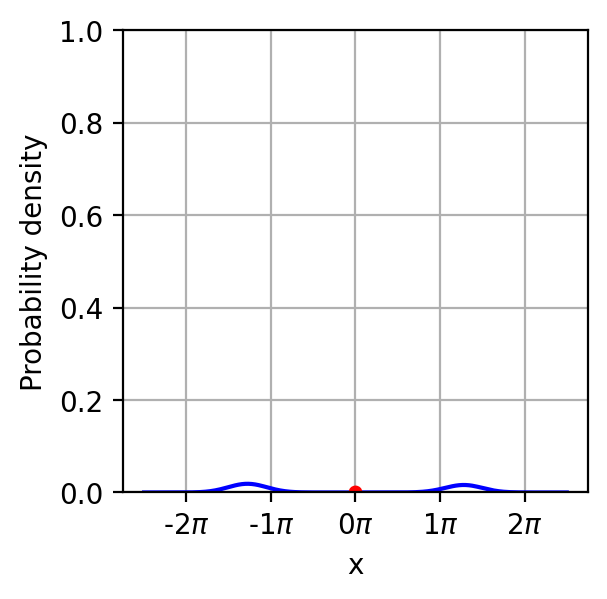

In [203]:
t_index = -1
mean_occupation_list = []
position_lattice_list = np.linspace(-L/2, L/2, N)
for i in range(N):
    mean_occupation_list.append(result_position_space[i][t_index])

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

#evolution of the probability density in position space
ax.plot(position_lattice_list, mean_occupation_list, color='blue', markersize=4)

#show the atoms on the x axis
ax.plot([x_A], [0], 'o', color='red', markersize=4)

#show proper labels
ax.set_xticks([i*pi for i in range(-1*int(L//(2*pi)), int(L//(2*pi)+1))])
ax.set_xticklabels([str(i)+'$\\pi$' for i in range(-1*int(L//(2*pi)),int(L//(2*pi)+1))])

ax.set_xlabel('x')
ax.set_ylabel('Probability density')
ax.set_ylim(0,1)
ax.grid()


plt.show()

Check also in momentum space

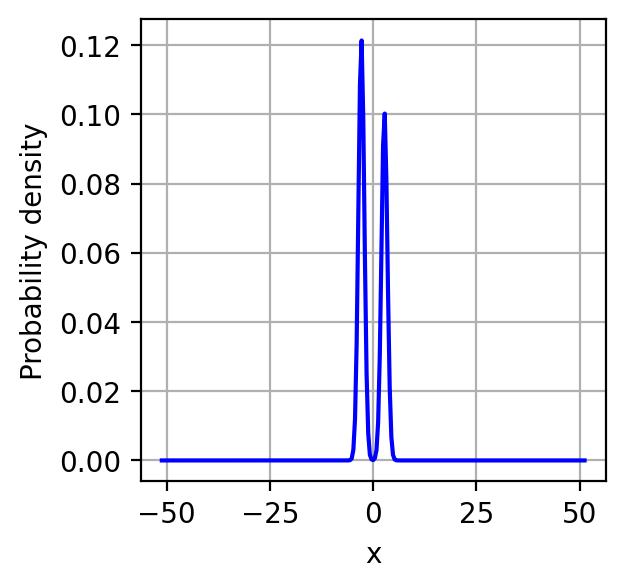

In [199]:
t_index = -1
mean_occupation_list = []

result_momentum_space = np.array(result_momentum_space)
n_modes = result_momentum_space.shape[0]
k_tab = np.array([2*pi*n/L for n in range(-(n_modes//2),n_modes//2+1)])

for i in range(n_modes):
    mean_occupation_list.append(result_momentum_space[i,t_index])

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

#evolution of the probability density in position space
ax.plot(k_tab, mean_occupation_list, color='blue', markersize=4)

ax.set_xlabel('x')
ax.set_ylabel('Probability density')

ax.grid()


plt.show()

Generate the animation

MovieWriter ffmpeg unavailable; using Pillow instead.


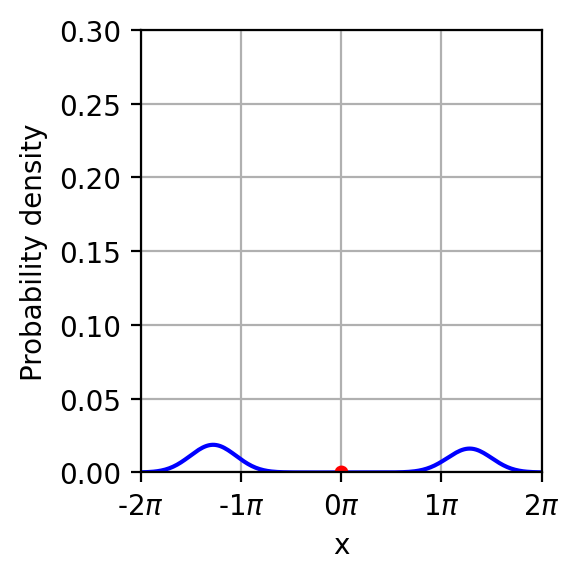

In [205]:
#animating the results from t=0 to t=99
from matplotlib.animation import FuncAnimation

nb_pts = len(times)
position_lattice_list = np.linspace(-L/2, L/2, N)
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

line, = ax.plot([], [], color='blue', markersize=4)
ax.plot([x_A], [0], 'o', color='red', markersize=4)
ax.set_xticks([i*pi for i in range(-1*int(L//(2*pi)), int(L//(2*pi)+1))])
ax.set_xticklabels([str(i)+'$\\pi$' for i in range(-1*int(L//(2*pi)),int(L//(2*pi)+1))])
ax.set_xlabel('x')
ax.set_ylabel('Probability density')
ax.set_ylim(0, 0.3)
ax.grid()

def init():
    line.set_data([], [])
    fig.tight_layout()
    return line,

def update(t):
    mean_occupation_list = []
    for i in range(N):
        mean_occupation_list.append(result_position_space[i][t])

    line.set_data(position_lattice_list, mean_occupation_list)
    fig.tight_layout()
    return line,

ani = FuncAnimation(fig, update, frames=nb_pts, init_func=init, blit=True)
ani.save('test_mirror.gif', writer='ffmpeg', fps=24)

plt.show()

Also for momentum

MovieWriter ffmpeg unavailable; using Pillow instead.


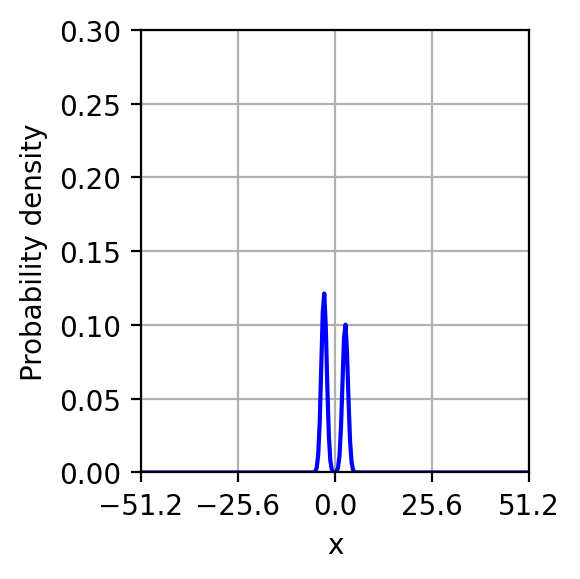

In [201]:
#animating the results from t=0 to t=99
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

result_momentum_space = np.array(result_momentum_space)
n_modes = result_momentum_space.shape[0]
k_tab = np.array([2*pi*n/L for n in range(-(n_modes//2),n_modes//2+1)])

line, = ax.plot([], [], color='blue', markersize=4)
ax.set_xticks([k_tab[i] for i in range(0, n_modes, n_modes//4)])
ax.set_xlabel('x')
ax.set_ylabel('Probability density')
ax.set_ylim(0, 0.3)
ax.grid()

def init():
    line.set_data([], [])
    fig.tight_layout()
    return line,

def update(t):
    mean_occupation_list = []
    for i in range(n_modes):
        mean_occupation_list.append(result_momentum_space[i][t])

    line.set_data(k_tab, mean_occupation_list)
    fig.tight_layout()
    return line,

ani = FuncAnimation(fig, update, frames=nb_pts, init_func=init, blit=True)
ani.save('test_mirror_momentum.gif', writer='ffmpeg', fps=24)

plt.show()

<h1> R and T coefficients </h1>

Try to define reflection and transmission cofficients ? Let me define:

$N_k = a_k^{\dagger} a_k$ and $N_x = a_x^{\dagger} a_x$ where :

$$a_x = \frac{1}{\sqrt{N}} \sum_k e^{ikx} a_k$$

I can define : 

$$P_-(t) = \sum_{x < 0} N_x \,\, , \,\, P_+(t) = \sum_{x > 0} N_x $$

It is also interesting to check that the atomic number remains close to zero :

$$ N_A = \sum_j \left(\frac{1+\sigma_j^z}{2}\right)$$

The transmission coefficient is $T = P_+(\infty)$ and the reflection is $R = P_-(\infty)$

T =  0.454970751951873
R =  0.5411226103165366


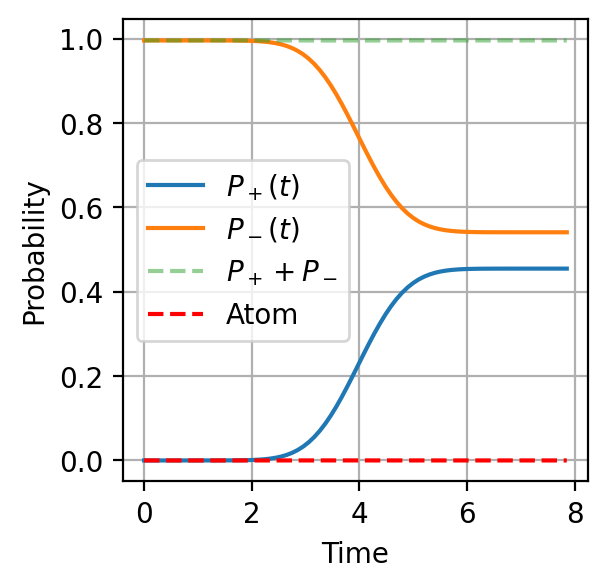

In [204]:
position_lattice_list = np.linspace(-L/2, L/2, N)
nb_pts = len(times)
T = np.zeros(nb_pts)
R = np.zeros(nb_pts)

for t in range(nb_pts):
    for x in range(N): 
        if position_lattice_list[x] > 0:
            T[t] += result_position_space[x][t]
        else:
            R[t] += result_position_space[x][t]

print("T = ", T[-1])
print("R = ", R[-1])

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(times, T, label=r'$P_+(t)$')
ax.plot(times, R, label=r'$P_-(t)$')
ax.plot(times, T+R, label=r'$P_+ + P_-$', linestyle='--', alpha=0.5) 
ax.plot(times, result_atom, label='Atom', linestyle='--', color='red')   
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()

plt.show()

<h1> Varying detunning </h1>

In [616]:
L = 5*pi
N = 64
T = L/2
#number of atom
n_A = 1
x_A = 0

g_0 = 1
omega_A = 5

#width of the wave packet
sigma = L/8
x_0 = -L/4

#modes quantization
n_modes = 64
use_WW_approx = True

nb_freq = 50
omega_0_tab = np.linspace(0, 10, nb_freq)
reflection_tab = np.zeros(nb_freq)

for i in tqdm(range(nb_freq)):
    omega_0 = omega_0_tab[i]
    #conduct time evolution
    times, result_momentum_space, result_position_space, result_coherence, result_atom = get_data_mirror(L, N, T, n_modes, omega_0, omega_A, n_A, g_0, x_A, sigma, x_0, use_WW_approx)
    #get the
    position_lattice_list = np.linspace(-L/2, L/2, N)
    nb_pts = len(times)
    reflection_coef = 0
    for x in range(N):
        if position_lattice_list[x] <= 0:
            reflection_coef += result_position_space[x][-1]
    reflection_tab[i] = reflection_coef

  0%|          | 0/50 [00:00<?, ?it/s]

Now plot the results ?

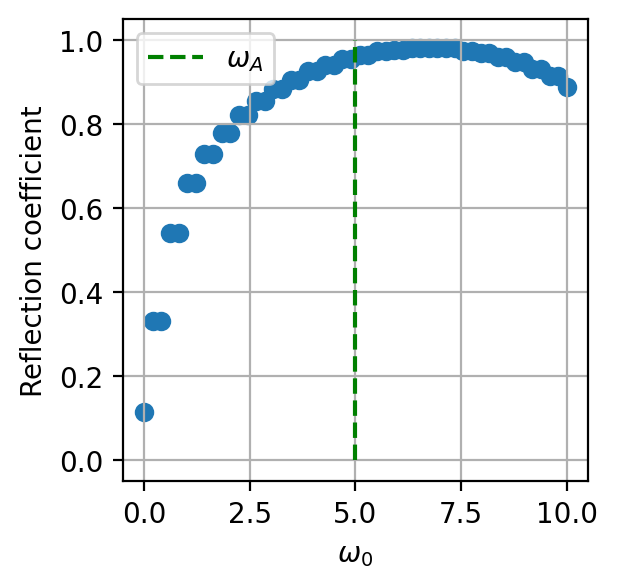

In [617]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)   
ax.scatter(omega_0_tab, reflection_tab)
ax.vlines(omega_A, 0, 1, color='green', linestyle='--', label='$\\omega_A$')
ax.set_xlabel('$\\omega_0$')
ax.set_ylabel('Reflection coefficient')
ax.grid()
ax.legend()

plt.show()